- **Project Title:** *Explainable Recommendations with BigQuery AI: From Profiles to Insights*
- **Problem Statement:** Most recommendation systems function as “black boxes,” surfacing items without offering context or transparency. This project uses BigQuery AI to automatically generate structured profiles of users and items, transform them into embeddings, and apply vector search to retrieve the most relevant matches. Each recommendation is then paired with an LLM-generated explanation, providing narrative reasoning that makes the system’s suggestions interpretable and trustworthy.
- **Impact Statement:** This solution shows how organizations can build scalable, explainable recommendation engines directly within BigQuery without the need for specialized machine learning teams. By combining personalization with transparency, the approach improves user trust, helps businesses uncover actionable behavioral patterns, and extends seamlessly to domains such as e-commerce and media.
- **Project Highlights**
    - Developed adaptable, structured profiles for users and recipes using BigQuery AI, enabling easy customization for various business domains.
    - Demonstrated that a straightforward recommendation system powered by BigQuery AI can slightly outperform the ALS baseline, simplifying implementation and highlighting the value of LLMs in recommendation workflows.
    - Created an interactive UI for users to browse personalized recommendations alongside clear, LLM-generated explanations.

# User & Recipe Profiles with BigQuery AI: From Embeddings to "Explainable" Recommendations


Inspired by the DoorDash blog post on [Profile Generation with LLMs](https://careersatdoordash.com/blog/doordash-profile-generation-llms-understanding-consumers-merchants-and-items/), this notebook showcases how to build user and recipe profiles leveraging BigQuery AI. It also outlines a workflow for generating potential recommendations, each paired with an "LLM-generated hypothesis" to provide narrative context for the suggestions.

This project addresses the challenges of **Approach 1 (The AI Architect)** and **Approach 2 (The Semantic Detective)** as described in the [Kaggle BigQuery Hackathon 2025](https://www.kaggle.com/competitions/bigquery-ai-hackathon/overview).

This notebook is structured as follows:

1. Data Sources
    - Datasets used (including sources and descriptions)
    - Preprocessing, splitting and uploading to BigQuery

2. (Approach 1) Recipe Profiles Generation
    - Profile schema design & prompt engineering
    - Using BigQuery AI to generate recipe profiles

3. (Approach 1) User Profiles Generation
    - Profile schema design & prompt engineering
    - Using BigQuery AI to generate user profiles

4. (Approach 2) Vector Search vs ALS
    - Using BigQuery AI to generate text embeddings
    - Simple collaborative filtering
    - Vector search for recommendations
        - Naive approach
        - HyDE (Hypothetical Document Embedding) approach
    - Comparing results with ALS baseline

5. (Approach 1) Explanation Generation
    - Prompt engineering for explanation generation
    - Using BigQuery AI to generate explanations for recommendations

6. LLM-as-a-Judge as middle ground between Offline Metrics and A/B Testing

7. (Approach 2) UI with Streamlit 
    - Hands-on interface to browse recommendations and their rationales
        - Automatic Personalized Recommendations
        - Semantic Search of Recipes

8. Summary and Conclusions
    - Feedback on BigQuery AI features
    - User Survey on BigQuery AI features

## Setup & Project Creation

In [1]:
import ast
import seaborn as sns
from tqdm import tqdm
import os, json
import matplotlib.pyplot as plt
from IPython.display import display
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
import os, ast, numpy as np, pandas as pd
import random
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import subprocess
import bigframes.pandas as bpd
from google.cloud import bigquery

np.set_printoptions(suppress=True, precision=2)
pd.set_option("display.float_format", "{:.3f}".format)

load_dotenv()

True

In [2]:
os.environ['PROJECT_ID'] = input("Enter your Google Cloud Project ID: ")
PROJECT_ID = os.environ['PROJECT_ID']

subprocess.run(['gcloud', 'auth', 'login'])
subprocess.run(['gcloud', 'config', 'set', 'project', PROJECT_ID])
subprocess.run(['gcloud', 'auth', 'application-default', 'set-quota-project', PROJECT_ID])

bpd.options.bigquery.project = PROJECT_ID

random.seed(0)

CONNECTION_ID = 'us.kaggle-connection'
SCHEMA_NAME = 'deliverable'

VALID_INTERACTIONS = f"{PROJECT_ID}.{SCHEMA_NAME}.valid_interactions_windowed"
TRAIN_INTERACTIONS = f"{PROJECT_ID}.{SCHEMA_NAME}.train_interactions_windowed"
SUBSET_RECIPE_IDS = f"{PROJECT_ID}.{SCHEMA_NAME}.final_recipes"
SUBSET_USERS_IDS = f"{PROJECT_ID}.{SCHEMA_NAME}.final_users"

RECIPES_ALL = f"{PROJECT_ID}.{SCHEMA_NAME}.recipes"
OUT_DIM = 1024

RECIPES_PARSED = f'{SCHEMA_NAME}.recipes_parsed'
RECIPES_PROFILES_TABLE = f"{SCHEMA_NAME}.recipe_profiles"

USERS_PARSED = f'{SCHEMA_NAME}.users_parsed'
USERS_PROFILES_TABLE = f"{SCHEMA_NAME}.user_profiles"

VECTOR_SEARCH_RESULTS_TABLE = f"{SCHEMA_NAME}.vector_search_results"

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=Medz5Ruj7eboye8tiUhy8kl1QTSbv5&access_type=offline&code_challenge=fWijhdCmAS4-EkH-LZhbJ8XvIpq7jtEb6AKc_Hk05cQ&code_challenge_method=S256



Opening in existing browser session.



You are now logged in as [jeremy.matos@utec.edu.pe].
Your current project is [kaggle-bigquery-471522].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].

Credentials saved to file: [/home/tenken/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "kaggle-bigquery-471522" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


We use a [BigQuery client](https://cloud.google.com/bigquery/docs/datasets) to interact with the service in a more Pythonic way

In [3]:
client = bigquery.Client()

In [4]:
dataset = bigquery.Dataset(f"{client.project}.{SCHEMA_NAME}")
dataset.location = "US"

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except Exception as e:
    print(e)

409 POST https://bigquery.googleapis.com/bigquery/v2/projects/kaggle-bigquery-471522/datasets?prettyPrint=false: Already Exists: Dataset kaggle-bigquery-471522:deliverable


We create a Cloud Resource connection to interact with Vertex AI services

In [5]:
subprocess.run(['bq', 'mk', '--connection', '--location=us', '--connection_type=CLOUD_RESOURCE', f'{CONNECTION_ID.replace("us.", "")}'])

BigQuery error in mk operation: Already Exists: Connection
projects/352240171839/locations/us/connections/kaggle-connection


CompletedProcess(args=['bq', 'mk', '--connection', '--location=us', '--connection_type=CLOUD_RESOURCE', 'kaggle-connection'], returncode=2)

Following the tutorials on [GitHub](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/bigquery_embeddings_vector_search.ipynb) we create a remote connection to the Text Embedding model

In [6]:
client.query_and_wait(f"""
CREATE OR REPLACE MODEL `{SCHEMA_NAME}.text_embedding_model`
REMOTE WITH 
    CONNECTION `{CONNECTION_ID}`
    OPTIONS (ENDPOINT = 'gemini-embedding-001');
""")

# Data Sources

For the dataset selection, three considerations were made:
- The datasets are publicly available (in line with the competition guidelines)
- The dataset should align with the goal of addressing a real-world problem using solutions that integrate naturally with SQL workflows.
- The dataset needs to include unstructured, messy, and mixed data


We utilize the [FoodRecSysV1](https://www.kaggle.com/datasets/elisaxxygao/foodrecsysv1) dataset from Kaggle, which provides comprehensive user interactions with recipes; including ratings, comments, and rich recipe metadata. This dataset closely mirrors the real-world challenges encountered by platforms such as Cookpad, DoorDash, UberEats, and Rappi.

Other datasets like [MealRec](https://arxiv.org/abs/2205.12133) and [MealRec++](https://github.com/WUT-IDEA/MealRecPlus) were also considered (and we can apply the same methodology of this notebook), but for the sake of simplicity and ease to start, we opted for FoodRecSysV1.


In [7]:
import kagglehub

path = kagglehub.dataset_download("elisaxxygao/foodrecsysv1")

print("Path to dataset files:", path)

Path to dataset files: /home/tenken/.cache/kagglehub/datasets/elisaxxygao/foodrecsysv1/versions/1


In [8]:
os.listdir(path)

['raw-data_interaction.csv',
 'core-data-valid_rating.csv',
 'core-data_recipe.csv',
 'raw-data-images',
 'core-data-test_rating.csv',
 'core-data-train_rating.csv',
 'core-data-images',
 'raw-data_recipe.csv']

In [9]:
def clean_df(core: pd.DataFrame) -> pd.DataFrame:
    core['user_id'] = core['user_id'].astype(str)
    core['recipe_id'] = core['recipe_id'].astype(str)
    core['dateLastModified'] = core['dateLastModified'].apply(lambda v: v.replace('\n', ''))
    core['dateLastModified'] = pd.to_datetime(core['dateLastModified'], format='ISO8601')
    core['month'] = core['dateLastModified'].dt.month
    core['quarter'] = core['dateLastModified'].dt.quarter
    core['rating'] = core['rating'].astype(float)
    
    core = core.dropna(how='any').sort_values(by=['dateLastModified'], ascending=[True])
    return core

core_train_rating = pd.read_csv(f'{path}/core-data-train_rating.csv')
core_train_rating = clean_df(core_train_rating)
display('train', core_train_rating.dtypes, core_train_rating.describe())
print(f"{core_train_rating.shape=}")


core_test_rating = pd.read_csv(f'{path}/core-data-test_rating.csv')
core_test_rating = clean_df(core_test_rating)
display('test', core_test_rating.dtypes, core_test_rating.describe())


core_val_rating = pd.read_csv(f'{path}/core-data-valid_rating.csv')
core_val_rating = clean_df(core_val_rating)
display('val', core_val_rating.dtypes, core_val_rating.describe())

recipes = pd.read_csv('./data/food_recsys/raw-data_recipe.csv')
recipes['recipe_id'] = recipes['recipe_id'].astype(str)

'train'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,676946.000,676946,676946.000,676946.000
mean,4.469,2008-10-12 19:03:51.871918336,6.496,2.502
min,1.000,2000-02-08 12:09:11.987000,1.000,1.000
25%,4.000,2007-07-20 09:30:30.988250112,3.000,1.000
50%,5.000,2009-05-15 03:51:38.998499840,7.000,3.000
75%,5.000,2010-08-31 19:02:24.820499968,10.000,4.000
max,5.000,2011-10-14 17:43:08.433000,12.000,4.000
std,0.860,NaN,3.574,1.148


core_train_rating.shape=(676946, 6)


'test'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,283440.000,283440,283440.000,283440.000
mean,4.510,2015-02-09 01:26:51.432288512,6.310,2.438
min,1.000,2013-01-31 22:55:07.660000,1.000,1.000
25%,4.000,2013-11-26 10:55:44.029000192,3.000,1.000
50%,5.000,2014-11-15 07:59:59.511500032,6.000,2.000
75%,5.000,2016-03-13 10:05:13.634749952,10.000,4.000
max,5.000,2018-03-15 03:09:12.853000,12.000,4.000
std,0.851,NaN,3.595,1.161


'val'

user_id                     object
recipe_id                   object
rating                     float64
dateLastModified    datetime64[ns]
month                        int32
quarter                      int32
dtype: object

,rating,dateLastModified,month,quarter
count,133459.000,133459,133459.000,133459.000
mean,4.506,2012-05-23 09:30:25.575911936,6.870,2.643
min,1.000,2011-10-14 17:46:56.443000,1.000,1.000
25%,4.000,2012-01-16 12:26:58.273499904,3.000,1.000
50%,5.000,2012-05-11 17:51:50.223000064,7.000,3.000
75%,5.000,2012-09-24 14:10:02.375000064,11.000,4.000
max,5.000,2013-01-31 22:23:27.613000,12.000,4.000
std,0.830,NaN,3.978,1.245


In [10]:
PREV_WEEKS = 24
POST_WEEKS = 4
MIN_INTERACTIONS_TRAIN = 5
MIN_INTERACTIONS_VAL = 5
print(f"Using last {PREV_WEEKS} weeks of training data to predict next {POST_WEEKS} weeks of ratings, with at least {MIN_INTERACTIONS_TRAIN} interactions in training and {MIN_INTERACTIONS_VAL} interactions in validation for each user")

min_date_val = core_train_rating['dateLastModified'].max() - pd.Timedelta(weeks=PREV_WEEKS)
max_date_val = core_val_rating['dateLastModified'].min() + pd.Timedelta(weeks=POST_WEEKS)

print(f"From {min_date_val} to {max_date_val}")

Using last 24 weeks of training data to predict next 4 weeks of ratings, with at least 5 interactions in training and 5 interactions in validation for each user
From 2011-04-29 17:43:08.433000 to 2011-11-11 17:46:56.443000


In [11]:
# Use training data of last N weeks only
core_train_rating = core_train_rating.loc[
    lambda df: df['dateLastModified'] >= min_date_val
]

# Reduce val predictions to next POST_WEEKS only
core_val_rating = core_val_rating.loc[
    lambda df: (df['dateLastModified'] <= max_date_val) & (df['rating'] >= 3)
]

# Find common users and recipes first
common_users = set(core_train_rating['user_id']).intersection(set(core_val_rating['user_id']))
common_recipes = set(core_train_rating['recipe_id']).intersection(set(core_val_rating['recipe_id']))
print(f"{len(common_users)=}, {len(common_recipes)=}")

# Filter both datasets to only include common users and recipes
train_users = core_train_rating[
    core_train_rating['user_id'].isin(common_users) & 
    core_train_rating['recipe_id'].isin(common_recipes)
]
val_users = core_val_rating[
    core_val_rating['user_id'].isin(common_users) & 
    core_val_rating['recipe_id'].isin(common_recipes)
]

common_users = set(train_users['user_id']).intersection(set(val_users['user_id']))
common_recipes = set(train_users['recipe_id']).intersection(set(val_users['recipe_id']))
print(f"{len(common_users)=}, {len(common_recipes)=}")

# Now filter by minimum interactions AFTER filtering by common users/recipes
train_user_counts = train_users['user_id'].value_counts()
val_user_counts = val_users['user_id'].value_counts()
train_recipe_counts = train_users['recipe_id'].value_counts()
val_recipe_counts = val_users['recipe_id'].value_counts()

# Users and recipes with at least MIN_INTERACTIONS interactions in FINAL filtered datasets
users_min_it_train = set(train_user_counts[train_user_counts >= MIN_INTERACTIONS_TRAIN].index)
users_min_it_val = set(val_user_counts[val_user_counts >= MIN_INTERACTIONS_VAL].index)

# Final common users and recipes with minimum interactions
final_users = users_min_it_train.intersection(users_min_it_val)

# Apply final filter
train_users = train_users[train_users['user_id'].isin(final_users)]
val_users = val_users[(val_users['user_id'].isin(final_users))]
final_recipes = set(train_users['recipe_id'].values).union(set(val_users['recipe_id'].values))

# Use final recipes for all recipe datasets
train_recipes = val_recipes = recipes[recipes['recipe_id'].isin(final_recipes)]


print(f"Final datasets: {len(train_users)} train interactions, {len(val_users)} val interactions")

# Verify minimum interactions constraint
print(f"Min interactions per user in train: {train_users['user_id'].value_counts().min()}")
print(f"Min interactions per user in val: {val_users['user_id'].value_counts().min()}")

display('train_users', train_users['user_id'].value_counts().sort_values(ascending=False))
display('val_users', val_users['user_id'].value_counts().sort_values(ascending=False))
print(f"Users: {len(final_users)}, Recipes: {len(final_recipes)}")


len(common_users)=3729, len(common_recipes)=3764
len(common_users)=2942, len(common_recipes)=2628
Final datasets: 2730 train interactions, 1066 val interactions
Min interactions per user in train: 5
Min interactions per user in val: 5


'train_users'

user_id
1037986    176
2043209    105
2448319    104
2702518     80
2995814     70
          ... 
2233245      5
6392312      5
3500863      5
2524829      5
4053273      5
Name: count, Length: 131, dtype: int64

'val_users'

user_id
1037986    31
2995814    29
2043209    29
2448319    24
6067445    21
           ..
3047421     5
484578      5
5017867     5
301943      5
1054570     5
Name: count, Length: 131, dtype: int64

Users: 131, Recipes: 2048


We'll finally use a total of 131 users and 2048 recipes, a size that balances data volume and execution time for demonstration purposes.


In [12]:
# Upload tables to BigQuery

train_users.to_gbq(TRAIN_INTERACTIONS, if_exists='replace')
val_users.to_gbq(VALID_INTERACTIONS, if_exists='replace')
train_recipes[['recipe_id']].to_gbq(SUBSET_RECIPE_IDS, if_exists='replace')
pd.DataFrame({'user_id': list(final_users)}).to_gbq(SUBSET_USERS_IDS, if_exists='replace')

/tmp/ipykernel_5601/349922751.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  train_users.to_gbq(TRAIN_INTERACTIONS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]
/tmp/ipykernel_5601/349922751.py:4: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  val_users.to_gbq(VALID_INTERACTIONS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]
/tmp/ipykernel_5601/349922751.py:5: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  train_recipes[['recipe_id']].to_gbq(SUBSET_RECIPE_IDS, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9

In [13]:
recipes.to_gbq(RECIPES_ALL, if_exists='replace')

/tmp/ipykernel_5601/1013056983.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  recipes.to_gbq(RECIPES_ALL, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 7219.11it/s]


Next, we're going to generate profiles in line with the [Spotify blog](https://research.atspotify.com/2025/9/profile-aware-llm-as-a-judge-for-podcasts-a-better-middle-ground-between). But first, let's define some utility functions:

In [14]:
def schema_to_prompt_with_descriptions(model_class) -> str:
    prompt = ""
    for k, v in model_class.model_json_schema()['properties'].items():
        desc = v.get('description', '')
        prompt += f" {k} ({desc}) "
    return f"[ {prompt} ]"

# Recipe Profiles Generation

We start cleaning and parsing some columns to make them suitable and more understandable for the LLM.

In [15]:
def prep_ingredients(text: str) -> str:
    if pd.isna(text): return ""
    return "\n".join([f"- {v}" for v in str(text).split('^')])


def prep_directions(text: str) -> str:
    if pd.isna(text): return ""
    s = str(text)
    # Some rows look like dict-strings with 'directions' inside; just fall back to raw text
    # Optionally, try to parse if it starts with "{"
    if s.strip().startswith("{"):
        try:
            d = ast.literal_eval(s)
            # common keys: 'directions' (string) or list
            v = d.get('directions', "")
            v = str(v).split('\n')
            v = [x.strip() for x in v if len(x.strip()) > 0]
            v = [f". {x}" if x and x[0].isupper() else x for x in v]

            return " ".join(v).strip(".").replace(" . ", ". ").replace("..", ".").strip()
        except Exception:
            return s.lower()
    return s.lower()


In [16]:
df_recipes = bpd.read_gbq(f"""
SELECT * FROM `{SUBSET_RECIPE_IDS}`
LEFT JOIN `{RECIPES_ALL}` USING(recipe_id)
""")

# Convert to pandas DataFrame to use custom functions, then back to BigFrames
df_recipes_pandas = df_recipes.to_pandas()

We create `parsed_ingredients` and `parsed_recipe` columns to then insert it into the prompt for profile generation.

In [17]:
nutrition_values = []
for idx, row in tqdm(df_recipes_pandas.iterrows(), total=len(df_recipes_pandas)):
    nutritions_dict = ast.literal_eval(row['nutritions'])
    
    row_info = {'recipe_id': row['recipe_id']}
    nutritions_info = {}
    for k in ['niacin', 'sugars', 'sodium', 'carbohydrates', 'vitaminB6', 'calories', 'thiamin', 'fat', 'folate', 'caloriesFromFat', 'calcium', 'fiber', 'magnesium', 'iron', 'cholesterol', 'protein', 'vitaminA', 'potassium', 'saturatedFat', 'vitaminC']:
        if k in nutritions_dict:
            nutritions_info[k] = nutritions_dict[k].get('percentDailyValue', -1)
            if nutritions_info[k] is not None:
                v = str(nutritions_info[k]).strip()
                if v == '< 1':
                    nutritions_info[k] = 0.0
                # if v == '-':
                #     nutritions_info[k] = -1
                
                try:
                    nutritions_info[k] = f"{nutritions_info[k]} percent"
                except Exception:
                    pass
    
    row_info['percent_daily_values'] = "\n".join([f"{k}: {v}" for k, v in nutritions_info.items()])
    nutrition_values.append(row_info)

nutrition_df = pd.DataFrame(nutrition_values).fillna(-2)

df_recipes_pandas['parsed_ingredients'] = df_recipes_pandas['ingredients'].apply(prep_ingredients)
df_recipes_pandas['parsed_recipe'] = df_recipes_pandas['cooking_directions'].apply(prep_directions)
df_recipes_pandas = df_recipes_pandas.merge(nutrition_df, how='left', on='recipe_id')
df_recipes_pandas['title'] = df_recipes_pandas['recipe_name']
df_recipes = bpd.DataFrame(df_recipes_pandas)

# Upload the new table in BigQuery
df_recipes.to_gbq(
    destination_table=f"{PROJECT_ID}.{RECIPES_PARSED}",
    if_exists='replace',
)

100%|██████████| 2048/2048 [00:01<00:00, 1874.92it/s]


'kaggle-bigquery-471522.deliverable.recipes_parsed'

Following the [DoorDash blog](https://careersatdoordash.com/blog/doordash-profile-generation-llms-understanding-consumers-merchants-and-items/) we define the structure and attributes of the "Recipe Profile" (item profiles). In this case we use a Pydantic model to define the schema, which then parsed as part of the prompt using the function `schema_to_prompt_with_descriptions`.

In [18]:
class RecipeProfile(BaseModel):
    food_type: str = Field(description="Type of food, e.g., dessert, main course, appetizer")
    cuisine_type: str = Field(description="Cuisine type, e.g., Italian, Chinese, Mexican, American")
    dietary_preferences: List[str] = Field(description="Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free")
    flavor_profile: List[str] = Field(description="Flavor profile, e.g., spicy, sweet, savory")
    serving_daypart: List[str] = Field(description="Suitable dayparts, e.g., breakfast, lunch, dinner")
    notes: str = Field(description="Short rationale summarizing the recipe profile")
    target_audience: str = Field(description="Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preferences. Helps recommendation systems match recipes to appropriate user profiles.")
    justification: str = Field(description="Detailed explanation of how the profile was determined Describe why the food type, cuisine type, dietary preferences, flavor profile, and serving daypart were chosen based on the ingredients and cooking directions. Is not allowed to use quotes or complex punctuation in this field.")


This schema could be enhanced by using more restrictive field types, such as `Enums` or `Literal` for categorical attributes. This would make it easier to apply business logic based on the extracted category metadata generated by the LLM in future iterations. 

Then, we define the prompt template to generate the recipe profiles, as follow:

In [19]:
recipe_profile_prompt = f"""Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: {schema_to_prompt_with_descriptions(RecipeProfile)}. IMPORTANT: Do not use quotation marks or complex punctuation in your response. Use simple words and avoid any quotes, apostrophes, or special characters."""

print(recipe_profile_prompt)

Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: [  food_type (Type of food, e.g., dessert, main course, appetizer)  cuisine_type (Cuisine type, e.g., Italian, Chinese, Mexican, American)  dietary_preferences (Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free)  flavor_profile (Flavor profile, e.g., spicy, sweet, savory)  serving_daypart (Suitable dayparts, e.g., breakfast, lunch, dinner)  notes (Short rationale summarizing the recipe profile)  target_audience (Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preferences. Helps recommendation systems match recipes to appropriate user profiles.)  justification (Detailed explanation of how the profile was determined Describe why the food type, cuisine type, dietary preferences, fla

We set the `temperature` parameter to **1.0** to promote creativity and encourage the model to explore a wide range of recipe characteristics during profile generation. The `maxOutputTokens` is set to `2048` to stay within the [Gemini Embedding Model's input token limit](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings). Additionally, we allocate up to `1024` thinking tokens to leverage the model’s reasoning abilities, aiming for a balance between accuracy and latency. Finally, we choose `gemini-2.5-flash` model for speed and cost efficiency.

<!-- https://developers.googleblog.com/en/gemini-embedding-available-gemini-api/ -->

In [20]:
recipe_profile_generation_query = f"""
WITH ai_responses AS (
  SELECT 
    s.recipe_id, 
    s.title, 
    s.ingredients, 
    s.cooking_directions, 
    s.nutritions, 
    s.reviews, 
    s.parsed_ingredients, 
    s.parsed_recipe,
    AI.GENERATE(('{recipe_profile_prompt}', s.parsed_ingredients, s.parsed_recipe, s.percent_daily_values),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-flash',
        model_params => JSON '{{"generationConfig":{{"temperature": 1.0, "maxOutputTokens": 2048, "thinking_config": {{"thinking_budget": 1024}} }} }}',
        output_schema => 'food_type STRING, cuisine_type STRING, dietary_preferences ARRAY<STRING>, flavor_profile ARRAY<STRING>, serving_daypart ARRAY<STRING>, notes STRING, target_audience STRING, justification STRING'
    ) AS ai_result
  FROM (SELECT * FROM `{RECIPES_PARSED}`) s
)
SELECT 
  *,
  ai_result.full_response AS recipe_profile,
  JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS recipe_profile_text
FROM ai_responses
"""

print(recipe_profile_generation_query)


WITH ai_responses AS (
  SELECT 
    s.recipe_id, 
    s.title, 
    s.ingredients, 
    s.cooking_directions, 
    s.nutritions, 
    s.reviews, 
    s.parsed_ingredients, 
    s.parsed_recipe,
    AI.GENERATE(('Based on the title, ingredients, cooking directions and percent daily values provided, create a recipe profile that summarizes the key characteristics of this recipe. Your response must follow this exact structure: [  food_type (Type of food, e.g., dessert, main course, appetizer)  cuisine_type (Cuisine type, e.g., Italian, Chinese, Mexican, American)  dietary_preferences (Dietary preferences, e.g., omnivore, vegetarian, vegan, gluten-free)  flavor_profile (Flavor profile, e.g., spicy, sweet, savory)  serving_daypart (Suitable dayparts, e.g., breakfast, lunch, dinner)  notes (Short rationale summarizing the recipe profile)  target_audience (Types of users who would likely enjoy this recipe based on cooking skill level, flavor intensity, dietary needs, and lifestyle preference

With this prompt, we can execute the SQL query using the BigQuery client. We encountered some challenges when specifying the prompt directly within the SQL query, such as issues with quotation marks (to highlight words), punctuation and line breaks, which are common in longer prompts. To mitigate these problems, we define the prompt as a single paragraph. It would be helpful if there were a way to use multi-line strings directly in SQL queries.

In [21]:
recipe_rows = client.query_and_wait(recipe_profile_generation_query)
df_recipes_profiles = recipe_rows.to_dataframe()

response = json.loads(df_recipes_profiles['recipe_profile'].iloc[0])
r_profile = json.loads(response['candidates'][0]['content']['parts'][0]['text'])
                      
print(json.dumps(response, indent=2))
print(json.dumps(json.loads(df_recipes_profiles['recipe_profile_text'].iloc[0]), indent=2))
print(f"{r_profile=}")

df_recipes_profiles.to_gbq(
    destination_table=f"{PROJECT_ID}.{RECIPES_PROFILES_TABLE}",
    if_exists='replace',
)

{
  "candidates": [
    {
      "avg_logprobs": -0.9889099980743838,
      "content": {
        "parts": [
          {
            "text": "{\n  \"cuisine_type\": \"Mexican\",\n  \"dietary_preferences\": [\n    \"vegetarian\"\n  ],\n  \"flavor_profile\": [\n    \"sweet\",\n    \"savory\",\n    \"tangy\"\n  ],\n  \"food_type\": \"main course\",\n  \"justification\": \"The food type is main course because the recipe involves substantial ingredients like sweet potatoes black beans and cheese enclosed in tortillas cooked and served in wedges making it a filling meal. The cuisine type is Mexican due to the prominent use of tortillas black beans and salsa which are staples in Mexican and Tex-Mex cooking along with the quesadilla preparation method. Dietary preferences are vegetarian because the ingredients include sweet potatoes black beans and tortillas which are plant-based along with cheddar cheese which is dairy but no meat or poultry is present. The flavor profile is sweet from the swee

/tmp/ipykernel_5601/584357236.py:11: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_recipes_profiles.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]


# User Profiles Generation

In [22]:
df_recipe_metadata = client.query_and_wait(f"""SELECT recipe_id, title, parsed_ingredients, parsed_recipe, recipe_profile_text, reviews FROM `{RECIPES_PROFILES_TABLE}`""").to_dataframe()

reviews = []
for idx, row in tqdm(df_recipe_metadata.iterrows(), total=len(df_recipe_metadata)):
    recipe_id = row['recipe_id']
    interactions_dict = ast.literal_eval(row['reviews'])
    for k, v in interactions_dict.items():
        reviews.append({
            'recipe_id': recipe_id,
            'user_id': str(k),
            **v
        })
reviews_df = pd.DataFrame(reviews)
reviews_df.columns = reviews_df.columns.str.lower()
reviews_df['datelastmodified'] = pd.to_datetime(reviews_df['datelastmodified'], format='mixed')

100%|██████████| 2048/2048 [01:13<00:00, 27.90it/s] 


In [23]:
SUBSET_COLS = 'user_id, recipe_id, rating, datelastmodified'
df_train_users = client.query_and_wait(f"""SELECT {SUBSET_COLS} FROM `{TRAIN_INTERACTIONS}`""").to_dataframe()
df_valid_users = client.query_and_wait(f"""SELECT {SUBSET_COLS} FROM `{VALID_INTERACTIONS}`""").to_dataframe()

In [24]:
# Drop users in valid not present in train_set
FINAL_USERS = set(df_train_users['user_id'].unique()).intersection(set(df_valid_users['user_id'].unique()))
print(f"Final users: {len(FINAL_USERS)}")

df_users_history = df_train_users[df_train_users['user_id'].isin(FINAL_USERS)].reset_index(drop=True)
df_users_history['datelastmodified'] = pd.to_datetime(df_users_history['datelastmodified'])
df_users_history = df_users_history.merge(
    reviews_df[['user_id', 'recipe_id', 'datelastmodified', 'text']], how='left', 
    on=['user_id', 'recipe_id', 'datelastmodified'],
    validate='one_to_one'
).rename(columns={'text': 'user_comment'})

df_valid_users = df_valid_users[df_valid_users['user_id'].isin(FINAL_USERS)].reset_index(drop=True)

print(df_users_history.describe())
print(df_valid_users.describe())

df_users_to_profile = df_valid_users.groupby('user_id').agg({'recipe_id': 'unique'}).reset_index().rename(columns={
    'recipe_id': 'rec_gt'
})  # , 'datelastmodified'

Final users: 131
        rating            datelastmodified
count 2730.000                        2730
mean     4.496  2011-07-27 01:47:37.662131
min      1.000  2011-04-29 18:43:20.453000
25%      4.000  2011-06-14 12:31:13.382750
50%      5.000  2011-07-29 09:15:59.395000
75%      5.000  2011-09-07 19:15:58.460500
max      5.000  2011-10-14 17:24:08.330000
std      0.757                         NaN
        rating            datelastmodified
count 1066.000                        1066
mean     4.559  2011-10-29 01:36:00.828909
min      3.000  2011-10-14 20:03:19.147000
25%      4.000  2011-10-22 12:28:31.182000
50%      5.000  2011-10-28 18:52:05.890000
75%      5.000  2011-11-05 06:16:04.777250
max      5.000  2011-11-11 17:43:12.483000
std      0.629                         NaN


For the user profile generation, we take advantage of the context window size of the Gemini models to provide a list of their historical interactions (ratings and comments) as part of the prompt.

In [ ]:
def get_user_history(user_id: int, n: int = 25, k_min: int = 5) -> list:
    """Get the top-n most recent recipes the user has interacted with."""
    user_history = df_users_history[df_users_history['user_id'] == user_id]
    user_history = user_history.sort_values(by='datelastmodified', ascending=False).head(n)
    assert len(user_history) >= k_min, f"User {user_id} has less than {k_min} interactions in the training set."

    user_history['date'] = user_history['datelastmodified'].dt.strftime('%Y-%m-%d')

    return user_history[['recipe_id', 'rating', 'date', 'user_comment']].to_dict('records')


def format_user_history(user_history: list[dict]) -> str:
    """Format the user history as a bulleted list."""

    user_info = ""
    avg_rating = 0
    for entry in user_history:
        recipe_metadata = df_recipe_metadata.loc[lambda df: df['recipe_id'] == entry['recipe_id'], ['recipe_id', 'title', 'parsed_ingredients', 'parsed_recipe', 'recipe_profile_text']].reset_index(drop=True).iloc[0]
        avg_rating += entry['rating']

        user_info += (
            f"\n>>> Recipe Title: {recipe_metadata['title']}\n"
            f">>> User Rating: {entry['rating']}\n"
            f">>> Date of Interaction: {entry['date']}\n\n"
            f">>> User Comment: {entry['user_comment']}\n\n"
            # TODO: Those columns are missing
            # f"Recipe Average Rating: {row['aver_rate']}\n"
            f">>> Ingredients:\n{recipe_metadata['parsed_ingredients']}\n\n"
            f">>> Cooking Directions:\n{recipe_metadata['parsed_recipe']}\n"
        )
        user_info += "--------------------------------------------\n"
    avg_rating /= len(user_history)
    user_info = f"The user has rated {len(user_history)} recipes, with an average rating of {avg_rating:.2f}.\n{user_info}"
    user_info = "########################################### USER HISTORY START ###########################################\n" + user_info
    user_info += "########################################### USER HISTORY END ###########################################\n"
    
    return user_info

'kaggle-bigquery-471522.deliverable.users_parsed'

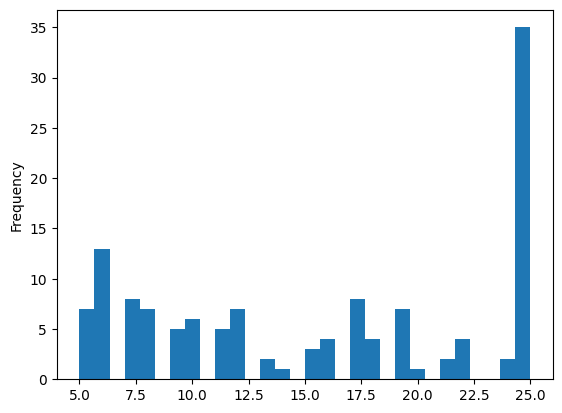

In [26]:
df_users_to_profile['user_history'] = df_users_to_profile['user_id'].apply(get_user_history)
df_users_to_profile['n_history'] = df_users_to_profile['user_history'].apply(len)

df_users_to_profile['n_history'].plot.hist(bins=30)

# print(format_user_history(df_users_to_profile['user_history'].iloc[0]))
df_users_to_profile['history_string'] = df_users_to_profile['user_history'].apply(format_user_history)

bpd.DataFrame(df_users_to_profile).to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PARSED}",
    if_exists='replace',
)

As in the recipe profiles, we define a Pydantic model, that it can be improved and adapted to the specific business case.

In [27]:
class UserProfile(BaseModel):
    liked_cuisines: List[str] = Field(description="List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings")
    cuisine_preference: str = Field(description="Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American)")
    dietary_preference: str = Field(description="Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions)")

    food_preferences: List[str] = Field(description="Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grilled meats)")
    top_cuisine_choices: List[str] = Field(description="Specific regional or ethnic cuisines the user frequently rates highly (e.g., Thai, Southern BBQ, French pastry)")
    dietary_preferences: List[str] = Field(description="Dietary restrictions, health considerations, or eating patterns (e.g., gluten-free, plant-based, high-protein, dairy-free)")
    flavor_preferences: List[str] = Field(description="Dominant taste profiles and flavor characteristics the user seeks (e.g., bold and spicy, mild and creamy, tangy and citrusy)")
    daypart_preferences: List[str] = Field(description="Preferred times of day for different meal types based on rating patterns (e.g., hearty breakfast, light lunch, elaborate dinner)")
    lifestyle_tags: List[str] = Field(description="Behavioral patterns and cooking style indicators inferred from recipe choices (e.g., quick meals, entertainer, health-conscious, experimental cook)")
    convenience_preference: str = Field(description="Preference for recipe complexity (e.g., quick and easy, gourmet elaborate)")
    diversity_openness: str = Field(description="Willingness to try new cuisines (e.g., adventurous, selective, traditionalist, not defined)")

    notes: str = Field(description="Brief summary explaining the users overall food personality and any notable patterns in their preferences")
    justification: str = Field(description="Detailed explanation of how the profile was determined based on the users interaction history and ratings. Describe why the liked cuisines, cuisine preference, dietary preference, food preferences, cuisine preferences, dietary preferences, flavor preferences, daypart preferences, and lifestyle tags were chosen. Is not allowed to use quotes or complex punctuation in this field. Keep it between 100 and 200 words not more.")
    user_story: str = Field(description="Predictive narrative about the user s culinary evolution and potential future preferences. Describes their food journey, emerging patterns, and likely directions for taste exploration. Written to help predict what they might enjoy next based on their current trajectory and evolving palate.")
    future_preferences: str = Field(description="Speculative insights into the types of recipes and cuisines the user may be inclined to explore in the future. Based on their current preferences, suggest new food categories, cooking styles, or dietary trends they might be open to trying next. This helps in anticipating their evolving culinary interests.")


In [28]:
user_profile_prompt = f"""Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: {schema_to_prompt_with_descriptions(UserProfile)}. Each fill of the structured output doesnt need to take more than 200 words keep it in mind. IMPORTANT: Do not use quotation marks or complex punctuation in your response. Use simple words and avoid any quotes, apostrophes, or special characters. Use the following interaction history as reference:"""

print(user_profile_prompt)

Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grilled meats))  top_cuisine_choices (Specific regional or ethnic cuisines the user frequently rates highly (e.g.

In [29]:
user_profile_generation_query = f"""
WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('{user_profile_prompt}', s.history_string),
        connection_id => '{CONNECTION_ID}',
        endpoint => 'gemini-2.5-flash',
        model_params => JSON '{{"generationConfig":{{"temperature": 1.0, "maxOutputTokens": 2048, "thinking_config": {{"thinking_budget": 1024}} }} }}',
        output_schema => 'liked_cuisines ARRAY<STRING>, cuisine_preference STRING, dietary_preference STRING, food_preferences ARRAY<STRING>, top_cuisine_choices ARRAY<STRING>, dietary_preferences ARRAY<STRING>, flavor_preferences ARRAY<STRING>, daypart_preferences ARRAY<STRING>, lifestyle_tags ARRAY<STRING>, convenience_preference STRING, diversity_openness STRING, notes STRING, justification STRING, user_story STRING, future_preferences STRING'
    ) AS ai_result
  FROM (SELECT * FROM `{USERS_PARSED}`) s
)
SELECT 
  *,
  ai_result.full_response AS user_profile,
  JSON_EXTRACT_SCALAR(ai_result.full_response, '$.candidates[0].content.parts[0].text') AS user_profile_text
FROM ai_responses
"""

print(user_profile_generation_query)


WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grille

In [30]:
print(user_profile_generation_query)
user_rows = client.query_and_wait(user_profile_generation_query)
df_users_profiles = user_rows.to_dataframe()

print(json.dumps(json.loads(df_users_profiles['user_profile_text'].iloc[0]), indent=2))

df_users_profiles.to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PROFILES_TABLE}",
    if_exists='replace',
)


WITH ai_responses AS (
  SELECT 
    s.user_id, 
    s.n_history,
    s.history_string,
    AI.GENERATE(('Generate a structured user profile that captures their culinary tastes, dietary preferences, flavor inclinations, among others. This user profile will be used then for a Recommendation System. Ensure the profile is concise, reasonable and accurately reflects the users food personality based on their interaction history. Please provide a structured profile of the user using the following format: [  liked_cuisines (List of cuisines the user enjoys most, ranked by preference based on their interaction history and ratings)  cuisine_preference (Primary cuisine type the user gravitates towards (e.g., Mediterranean, Asian Fusion, Traditional American))  dietary_preference (Main dietary restriction or lifestyle the user follows (e.g., Vegetarian, Low-carb, No restrictions))  food_preferences (Preferred food categories and meal types (e.g., comfort food, healthy salads, baked goods, grille

/tmp/ipykernel_5601/2933704288.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_users_profiles.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8004.40it/s]


# Vector Search vs ALS


We begin creating the text embeddings for both users and recipes, as follow:

In [31]:
client.query_and_wait(f"""
ALTER TABLE `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
ADD COLUMN text_embedding ARRAY<FLOAT64>
""")

client.query_and_wait(f"""
UPDATE `{PROJECT_ID}.{USERS_PROFILES_TABLE}` AS t
SET t.text_embedding = s.ml_generate_embedding_result
FROM (
  SELECT
    user_id,
    ml_generate_embedding_result
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `{SCHEMA_NAME}.text_embedding_model`,
      (
        SELECT
          user_id,
          user_profile_text AS content
        FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}`
      ),
      STRUCT(TRUE AS flatten_json_output, {OUT_DIM} AS OUTPUT_DIMENSIONALITY, 'RETRIEVAL_QUERY' AS task_type)
    )
) AS s
WHERE t.user_id = s.user_id
""")

In [ ]:
client.query_and_wait(f"""
ALTER TABLE `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
ADD COLUMN text_embedding ARRAY<FLOAT64>
""")

# Create Vector Embeddings for the recipe profiles
client.query_and_wait(f"""
UPDATE `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}` AS t
SET t.text_embedding = s.ml_generate_embedding_result
FROM (
  SELECT
    recipe_id,
    ml_generate_embedding_result
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `{SCHEMA_NAME}.text_embedding_model`,
      (
        SELECT
          recipe_id,
          recipe_profile_text AS content
        FROM `{PROJECT_ID}.{RECIPES_PROFILES_TABLE}`
      ),
      STRUCT(TRUE AS flatten_json_output, {OUT_DIM} AS OUTPUT_DIMENSIONALITY, 'RETRIEVAL_DOCUMENT' AS task_type)
    )
) AS s
WHERE t.recipe_id = s.recipe_id
""")

In [ ]:
# Parse column to exclude recipe_history from vector search
df = client.query_and_wait(f"""
SELECT * FROM `{PROJECT_ID}.{USERS_PARSED}`
""").to_dataframe()

df['recipes_to_exclude'] = df['user_history'].apply(lambda x: [entry['recipe_id'] for entry in x])

# Update entire table with the new column
df.to_gbq(
    destination_table=f"{PROJECT_ID}.{USERS_PARSED}",
    if_exists='replace',
)

# Add new column to user profiles table via left join
client.query_and_wait(f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{USERS_PROFILES_TABLE}` AS
SELECT u.*, p.recipes_to_exclude, p.rec_gt
FROM `{PROJECT_ID}.{USERS_PROFILES_TABLE}` u
LEFT JOIN `{PROJECT_ID}.{USERS_PARSED}` p USING(user_id)
""")

We could then reduce the search space of the vector search query using business logic. For example, we could filter recipes by cuisine, meal type, or dietary restrictions based on the user's preferences. This would help in retrieving more relevant recommendations. But, it is out of the scope of this notebook.

## Naive Approach (Collaborative Filtering)

## Simple Vector Search 

This semantic search approach address in certain way the cold-start problem, as it can recommend new recipes that have not been rated yet, based on their content and similarity to the user's profile.

## HyDE (Hypothetical Document Embedding) Approach

## ALS

Traditional Rec Sys methods fail to determine why a recommendation is relevant to a user.

We see in other competitions like [H&M](https://www.kaggle.com/code/julian3833/h-m-implicit-als-model-0-014) and in papers like ...

If we'd had a more reliable retriever (powered by any algorithm, heuristic or methodology), we could have used `AI.GENERATE` method to re-rank the retrieved candidates as in [LlamaRec](https://arxiv.org/pdf/2311.02089). Some RecSys ideas can be found in more advanced papers like [LRU](https://arxiv.org/pdf/2310.02367) or [Generative Retrieval](https://papers.neurips.cc/paper_files/paper/2023/file/20dcab0f14046a5c6b02b61da9f13229-Paper-Conference.pdf)

# LLM-as-a-Judge as middle ground between Offline Metrics and A/B Testing

Inspired by the work of [Spotify](https://arxiv.org/abs/2508.08777)

Following the ideas of this [Spotify paper](https://dl.acm.org/doi/pdf/10.1145/3705328.3759305)

# UI with Streamlit

# Summary and Conclusions

## Feedback on BigQuery AI features
- We found difficult at the beggining to pass the description of the attributes of the Pydantic models (used in libraries like LangChain and Instructor) as schema for the LLM calls. As you see in the code, we had to create a function to create a part of the prompt with the description of each attribute. It would be great to have a more straightforward way to do this.
- The LLM calls are quite slow, even using the lightweight models. We had to limit the number of recipes and users to process. It would be great to have a way to speed up the calls, and show the progress of the calls.
- If a response is too lengthy and surpasses the maximum tokens limit, it may cause errors related to quotation marks. Improving error messages and handling for these cases would make debugging easier and prevent the entire query from failing due to such edge cases.
- We found that sometimes the Gemini Embedding 001 model returns empty embeddings for certain inputs. ...
- Use two decimal places for the temperature value lead into an error in the SQL query.

## User Survey on BigQuery AI features